In [421]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import brentq

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [422]:
def saturation(x,*param):
    slope = param[0]
    sat   = param[1]
    shift = param[2]
    gain  = param[3]
    #offset = param[4]

    value = gain*(1 + ((slope*(x-shift))/np.power(1+np.power((np.abs(slope*(x-shift))),sat),1./sat))) 

    return value

In [427]:
class fitting_nohist(object):
    def __call__(self, data, time, fit_func, guess, sigmas, bounds=[]):
        self.bins  = time
        self.data  = data
        self.fit_func = fit_func
        self.guess  = guess
        self.bounds = bounds
        
        try:
            self.coeff, self.var_matrix = curve_fit(self.fit_func, self.bins,
                                                    self.data, p0=self.guess,
                                                    ftol=1E-12, maxfev=100000,
                                                    #bounds=self.bounds,
                                                    method='lm'
                                                    )

            self.perr = np.sqrt(np.absolute(np.diag(self.var_matrix)))
            # Error in parameter estimation
        except:
            print("Fitting Problems")
        
        self.fit = self.fit_func(self.bins, *self.coeff)
        self.chisq = np.sum(((self.data-self.fit)/sigmas)**2)
        self.df = len(self.bins)-len(self.coeff)
        self.chisq_r = self.chisq/self.df
        #Gets fitted function and chisqr_r

    def evaluate(self,in_data):
        return self.fit_func(in_data,*self.coeff)

In [428]:
def Baseline_work(data, canal, counter):
    datos = data[(data.channel_id==canal)&(data.vth_t1==62)]  
    counter_max = datos['count'].max()    
    magic_point = 0.999*counter_max    
    select = datos[(datos['count'] >= magic_point)]    
    return select['baseline_t'].max()
    

In [429]:
def Tn_fit(data, canal, min_count=10, plot=False, guess=[1.83, 11.11, 55.7,  
                                                          2.1e+06]):
    slope = guess[0]
    sat   = guess[1]
    shift = guess[2]
    gain  = guess[3]
    #offset = guess[4]
    
    baseline_T = Baseline_work(data, canal, 2**22)
    baseline_T = baseline_T - 5   # 5 is a guess for a better fit of THn
    print("Baseline %f" % baseline_T)
    
    datos = data[(data['channel_id']==canal) & (data['baseline_t']==baseline_T)]

    T_fit = fitting_nohist()

    T_fit(datos['count'],datos['vth_t1'],saturation,[slope,sat,shift,gain],
          np.zeros(len(datos['count']))+1.0)
        
    #chisq = np.sum(((datos['count']-T_fit.evaluate(datos['vth_t1']))/1.0)**2)
    print("Channel = %d / CHISQR = %f" % (canal,T_fit.chisq_r))
    
           
    if plot==True:
        plt.figure()
        plt.plot(np.arange(0,64,0.1),T_fit.evaluate(np.arange(0,64,0.1)),'b-',label="Fit")
        plt.errorbar(datos['vth_t1'],datos['count'], 1.0,
                     fmt='.',color='red',label="Data")
        plt.xlabel("th_T1")
        plt.ylabel("COUNT")
        plt.legend()
    
    func = lambda x : min_count - saturation(x,*T_fit.coeff)
    t_solution = np.floor(brentq(func, 0, 62))
    print("Threshold at %f for a 0.01 activity" % t_solution)
    print(T_fit.coeff)
    return t_solution

Baseline 57.000000
Channel = 13 / CHISQR = 0.000000


<IPython.core.display.Javascript object>


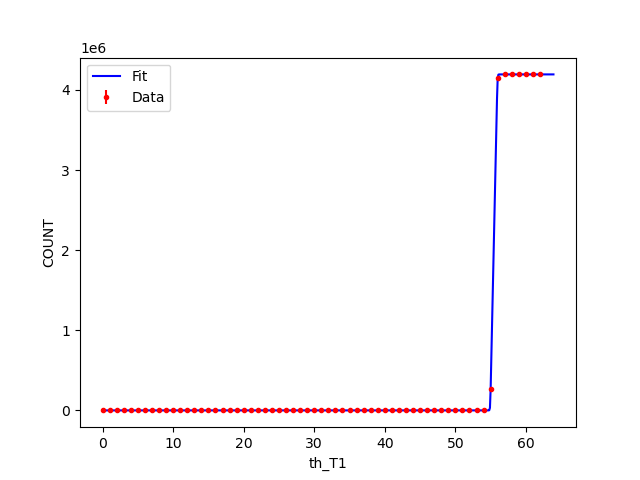

Threshold at 54.000000 for a 0.01 activity
[1.92513813e+00 1.76299229e+01 5.54547560e+01 2.09715200e+06]


54.0

In [433]:
filename = "/home/viherbos/DATA_daq/threshold_calibration_16ch_baseline_vs_t1.h5"
data = pd.read_hdf(filename)

Tn_fit(data,13,(2**22)*0.001,plot=True)